In [1]:
# Step 1: Install dependencies
!pip install numpy==1.26.4 tensorflow==2.18.0 gensim==4.3.3 wordcloud==1.9.3 streamlit==1.39.0 nltk==3.8.1 pandas==2.2.3 scikit-learn==1.5.2 matplotlib==3.9.2 seaborn==0.13.2 pyngrok==7.2.0 -q

In [2]:
!pip install --upgrade --force-reinstall numpy==1.26.4
!pip install --upgrade --force-reinstall gensim==4.3.3

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.

In [3]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import streamlit as st
import pickle
import gensim.downloader

import os


In [4]:
# prompt: connect drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def download_nltk_resources():
    resources = ['punkt', 'stopwords', 'wordnet']  
    for resource in resources:
        try:
            nltk.data.find(f'tokenizers/{resource}' if resource in ['punkt'] else f'corpora/{resource}')  # Check if 'punkt' or 'corpora'
            print(f"{resource} already downloaded.")
        except LookupError:
            print(f"Downloading {resource}...")
            nltk.download(resource, quiet=True)
            print(f"{resource} downloaded successfully.")

download_nltk_resources()

punkt already downloaded.
stopwords already downloaded.
wordnet downloaded successfully.


In [6]:
# Step 5: Preprocessing function
def clean_text(text):
    try:
        if not isinstance(text, str):
            return ''
        text = text.lower()
        text = re.sub(r'http\s+|www\s+|https\s+|@\w+|#\w+|\d+|[^a-z\s]', '', text)
        contractions = {
            "isn't": "is not", "aren't": "are not", "won't": "will not", "can't": "cannot",
            "don't": "do not", "i'm": "i am", "you're": "you are", "it's": "it is"
        }
        for contr, expanded in contractions.items():
            text = text.replace(contr, expanded)
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens) if tokens else ''
    except Exception as e:
        print(f"Error in clean_text: {e}")
        return ''

# Test preprocessing
sample_text = "This hotel isn't great, but it's okay. #hotel @user https://example.com"
print("Sample text:", sample_text)
print("Cleaned text:", clean_text(sample_text))


Sample text: This hotel isn't great, but it's okay. #hotel @user https://example.com
Cleaned text: hotel isnt great okay httpsexamplecom


In [7]:
# Step 6: Load dataset
data_path = '/content/drive/MyDrive/Level6_AI/Assignment-2/Hotel_Reviews.csv'
data = pd.read_csv(data_path)
print("Columns:", data.columns)
print("Dataset shape:", data.shape)
print("Rating distribution:\n", data['Rating'].value_counts())

Columns: Index(['Review', 'Rating'], dtype='object')
Dataset shape: (20491, 2)
Rating distribution:
 Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64


In [8]:
# Step 7: Apply cleaning
data['cleaned_text'] = data['Review'].apply(clean_text)
print("First few cleaned reviews:\n", data['cleaned_text'].head())
print("Empty reviews:", (data['cleaned_text'] == '').sum())
# Remove empty reviews
data = data[data['cleaned_text'] != '']
print("Dataset shape after removing empty reviews:", data.shape)

First few cleaned reviews:
 0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice room experience hotel monaco seattle good...
3    unique great stay wonderful time hotel monaco ...
4    great stay great stay went seahawk game awesom...
Name: cleaned_text, dtype: object
Empty reviews: 0
Dataset shape after removing empty reviews: (20491, 3)


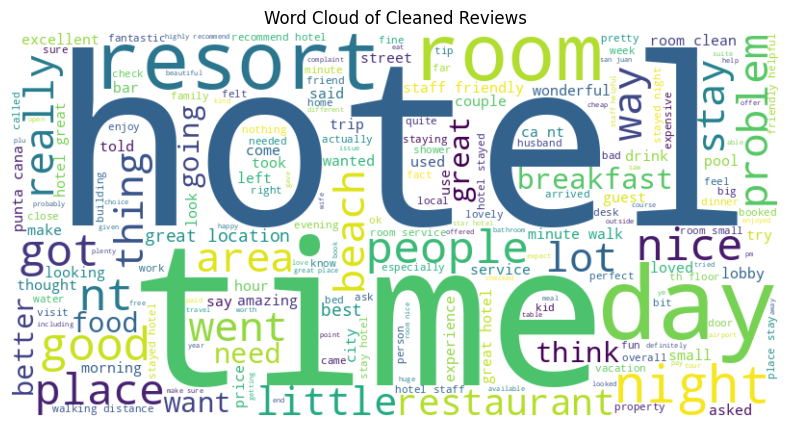

In [9]:
# Step 8: Visualize with word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['cleaned_text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Reviews')
plt.show()

In [10]:
# Step 9: Prepare data
X = data['cleaned_text']
y = data['Rating'] - 1  # Convert ratings 1-5 to 0-4
y = pd.get_dummies(y).values  # One-hot encode


In [11]:
# Step 10: Tokenization
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

In [12]:
# Step 11: Fixed padding
max_length = 100
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')

# Validate input data
print("X_pad shape:", X_pad.shape)
print("y shape:", y.shape)
print("Max token index:", X_pad.max())
if X_pad.max() >= vocab_size:
    print("Warning: Token indices exceed vocab_size!")
else:
    print("Token indices are valid.")
print("NaNs in X_pad:", np.isnan(X_pad).sum())
print("NaNs in y:", np.isnan(y).sum())

X_pad shape: (20491, 100)
y shape: (20491, 5)
Max token index: 9999
Token indices are valid.
NaNs in X_pad: 0
NaNs in y: 0


In [13]:
# Step 12: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=np.argmax(y, axis=1), random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16392, 100)
y_train shape: (16392, 5)
X_test shape: (4099, 100)
y_test shape: (4099, 5)


In [14]:
# Step 13: Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: 2.883377308707124, 1: 2.2861924686192467, 2: 1.876588437321122, 3: 0.6786172635065204, 4: 0.45263012563854754}


In [15]:
# Step 14: Load or cache Word2Vec embeddings
embedding_file = '/content/word2vec_embedding_matrix.npy'
if os.path.exists(embedding_file):
    print("Loading cached Word2Vec embeddings...")
    embedding_matrix = np.load(embedding_file)
else:
    print("Loading Word2Vec embeddings...")
    word2vec_model = gensim.downloader.load('word2vec-google-news-300')  # Modified line
    embedding_dim = 300
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word_index = tokenizer.word_index
    for word, i in word_index.items():
        if i < vocab_size and word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
    np.save(embedding_file, embedding_matrix)
    print("Word2Vec embeddings cached.")
print("Embedding matrix shape:", embedding_matrix.shape)

Loading Word2Vec embeddings...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec embeddings cached.
Embedding matrix shape: (10000, 300)


In [23]:
# Step 15: Define models with input shape
# Model 1: Simple RNN
model1 = Sequential([
    Embedding(vocab_size, 128, input_shape=(max_length,)),
    SimpleRNN(32, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(5, activation='softmax')
])
model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=['accuracy'])
model1.summary()

# Model 2: LSTM (Simplified)
model2 = Sequential([
    Embedding(vocab_size, 128, input_shape=(max_length,)),
    LSTM(16, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(5, activation='softmax')
])
model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=['accuracy'])
model2.summary()

# Model 3: LSTM with Word2Vec
model3 = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_shape=(max_length,), trainable=False),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])
model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=['accuracy'])
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,285,765 (4.90 MB)

 Trainable params: 1,285,765 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289,637 (4.92 MB)

 Trainable params: 1,289,637 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,229 (12.31 MB)

 Trainable params: 228,229 (891.52 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [24]:
# Step 16: Training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
print("Training Model 1: Simple RNN...")
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)
print("Training Model 2: LSTM...")
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)
print("Training Model 3: LSTM with Word2Vec...")
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

Training Model 1: Simple RNN...
Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2590 - loss: 1.6170 - val_accuracy: 0.3394 - val_loss: 1.5792
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3232 - loss: 1.5769 - val_accuracy: 0.3489 - val_loss: 1.5651
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4525 - loss: 1.4216 - val_accuracy: 0.4724 - val_loss: 1.2586
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5877 - loss: 1.0153 - val_accuracy: 0.5084 - val_loss: 1.1399
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6919 - loss: 0.7106 - val_accuracy: 0.4925 - val_loss: 1.1783
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7206 - loss: 0.5401 - val_accuracy: 0.4867 - val_loss: 1.2340
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7870 - loss: 0.4035 - val_accuracy: 0.4773 - val_loss: 1.3371
Training Model 2: LSTM...
Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━

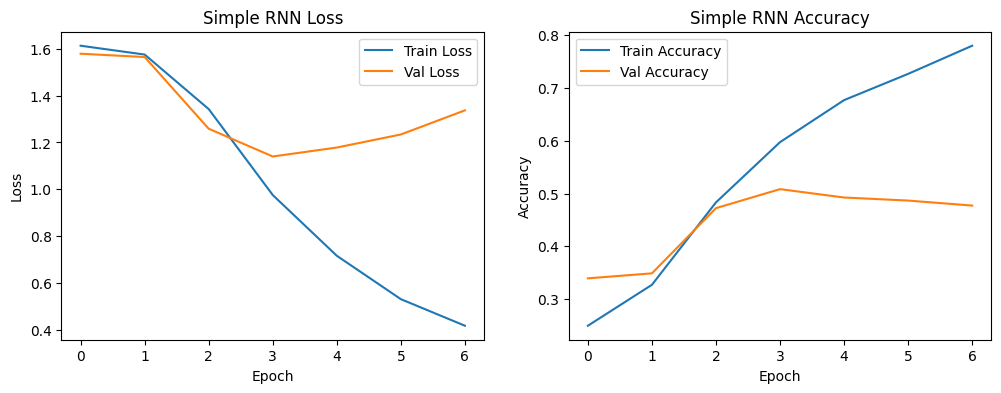

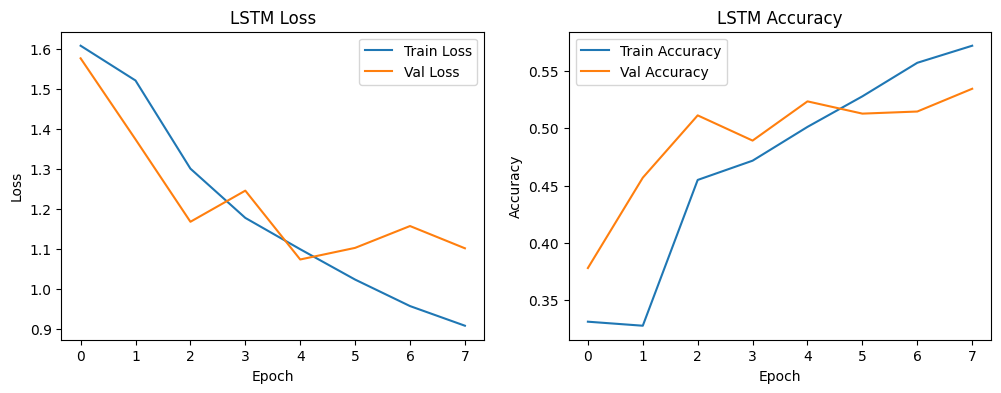

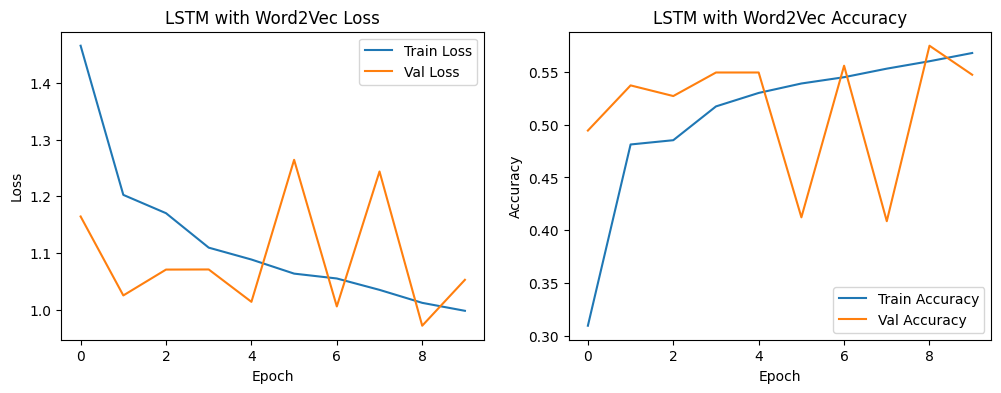

In [25]:
# Step 17: Plot training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history1, 'Simple RNN')
plot_history(history2, 'LSTM')
plot_history(history3, 'LSTM with Word2Vec')

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Model 1 Accuracy: 0.480848987557941
Model 1 Confusion Matrix:
 [[ 163   81   29    4    7]
 [ 164   79   53   14   49]
 [ 110   74   59   32  162]
 [  66   61   96  110  875]
 [  27   31   42  151 1560]]
Model 1 Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.57      0.40       284
           1       0.24      0.22      0.23       359
           2       0.21      0.14      0.16       437
           3       0.35      0.09      0.14      1208
           4       0.59      0.86      0.70      1811

    accuracy                           0.48      4099
   macro avg       0.34      0.38      0.33      4099
weighted avg       0.43      0.48      0.42      4099



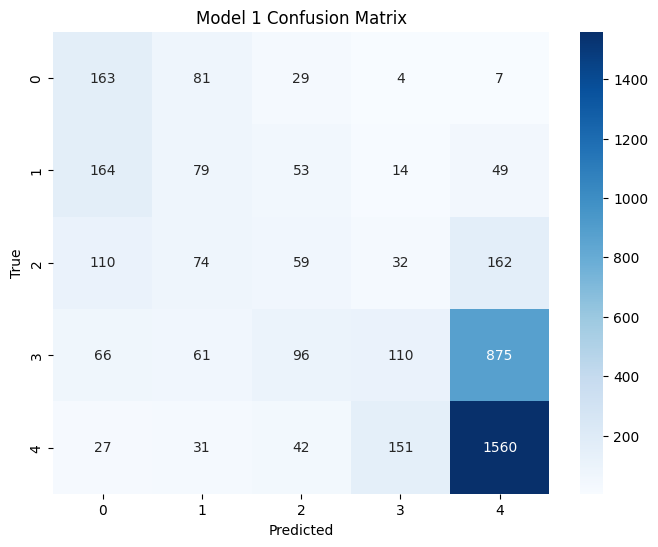

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model 2 Accuracy: 0.5132959258355696
Model 2 Confusion Matrix:
 [[ 194   41   33    2   14]
 [ 109   45  125   13   67]
 [  31   42  128   24  212]
 [   9   16  135   25 1023]
 [   3    8   75   13 1712]]
Model 2 Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.68      0.62       284
           1       0.30      0.13      0.18       359
           2       0.26      0.29      0.27       437
           3       0.32      0.02      0.04      1208
           4       0.57      0.95      0.71      1811

    accuracy                           0.51      4099
   macro avg       0.40      0.41      0.36      4099
weighted avg       0.44      0.51      0.41      4099



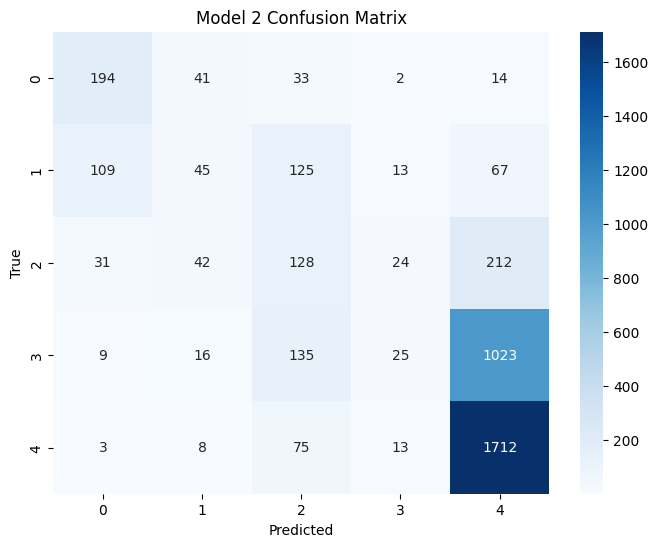

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Model 3 Accuracy: 0.5635520858746036
Model 3 Confusion Matrix:
 [[ 161   96   23    2    2]
 [  50  122  158   20    9]
 [   8   68  217  108   36]
 [   2   29  236  478  463]
 [   2   20  120  337 1332]]
Model 3 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.57      0.64       284
           1       0.36      0.34      0.35       359
           2       0.29      0.50      0.36       437
           3       0.51      0.40      0.44      1208
           4       0.72      0.74      0.73      1811

    accuracy                           0.56      4099
   macro avg       0.52      0.51      0.50      4099
weighted avg       0.58      0.56      0.57      4099



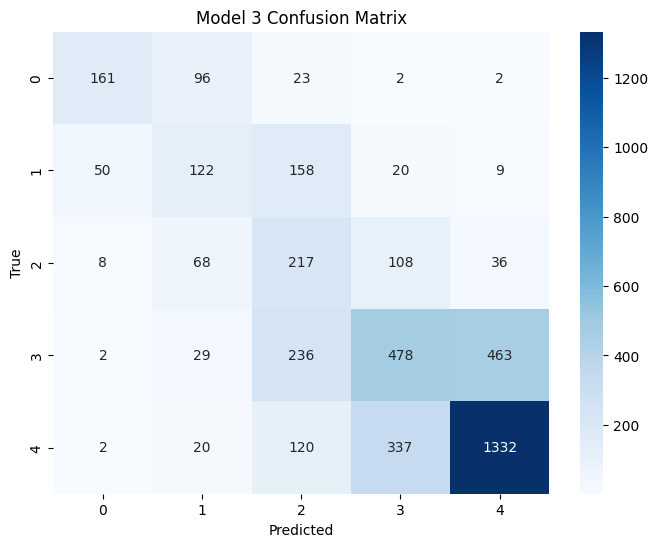

In [26]:
# Step 18: Evaluate models
y_test_labels = np.argmax(y_test, axis=1)
for i, model in enumerate([model1, model2, model3], 1):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"Model {i} Accuracy:", accuracy_score(y_test_labels, y_pred))
    print(f"Model {i} Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred))
    print(f"Model {i} Classification Report:\n", classification_report(y_test_labels, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test_labels, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Model {i} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [27]:
# Step 19: Save model and tokenizer
model3.save('/content/sentiment_model.h5')
with open('/content/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Model and tokenizer saved.")


Model and tokenizer saved.


In [28]:
# Step 20: Streamlit app
%%writefile /content/app.py
import streamlit as st
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import pickle

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

model = load_model('/content/sentiment_model.h5')
with open('/content/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\s+|www\s+|https\s+|@\w+|#\w+|\d+|[^a-z\s]', '', text)
    contractions = {
        "isn't": "is not", "aren't": "are not", "won't": "will not", "can't": "cannot",
        "don't": "do not", "i'm": "i am", "you're": "you are", "it's": "it is"
    }
    for contr, expanded in contractions.items():
        text = text.replace(contr, expanded)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

st.title('Hotel Review Sentiment Analysis')
st.write('Enter a hotel review to predict its rating (1–5 stars).')
user_input = st.text_area('Enter Review:', height=200)
max_length = 100

if st.button('Predict'):
    if not user_input.strip():
        st.error('Please enter a review.')
    else:
        try:
            cleaned_text = clean_text(user_input)
            seq = tokenizer.texts_to_sequences([cleaned_text])
            padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
            prediction = model.predict(padded_seq)
            rating = np.argmax(prediction) + 1
            st.success(f'The predicted rating is: {rating} ⭐')
        except Exception as e:
            st.error(f'Error processing review: {e}')


Overwriting /content/app.py


In [29]:
# Step 21: Instructions for Streamlit (run manually)
print("To run Streamlit app locally, download 'app.py', 'sentiment_model.h5', and 'tokenizer.pkl' to your local machine and run:")
print("  streamlit run app.py")
print("To run in Colab, set up ngrok (requires auth token):")
print("""
  !ngrok authtoken YOUR_NGROK_TOKEN
  !streamlit run /content/app.py &>/dev/null &
  !ngrok http 8501
""")
print("Replace YOUR_NGROK_TOKEN with your ngrok auth token from https://dashboard.ngrok.com/get-started/your-authtoken")

To run Streamlit app locally, download 'app.py', 'sentiment_model.h5', and 'tokenizer.pkl' to your local machine and run:
  streamlit run app.py
To run in Colab, set up ngrok (requires auth token):

  !ngrok authtoken YOUR_NGROK_TOKEN
  !streamlit run /content/app.py &>/dev/null &
  !ngrok http 8501

Replace YOUR_NGROK_TOKEN with your ngrok auth token from https://dashboard.ngrok.com/get-started/your-authtoken
